In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from torchsummary import summary
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [3]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

label = data[:,0]
data = data[:, 1:]
data = data/np.max(data)

img_data = data.reshape(data.shape[0], 1, 28,28)
img_data.shape

(20000, 1, 28, 28)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(torch.tensor(img_data).float(),
                                                    torch.tensor(label).long(),
                                                    test_size=0.15)

train_loader = TensorDataset(x_train, y_train)
test_loader = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_loader, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_loader, batch_size=test_loader.tensors[0].shape[0])

In [7]:
train_loader.dataset.tensors[0].shape

torch.Size([17000, 784])

In [22]:
def create_MNIST_CNN():
    class mnistNet(nn.Module):
        def __init__(self, img_width=28):
            super().__init__()
            
            self.cv1 = nn.Conv2d(1,10,kernel_size=5, stride=1,padding=1)
            out_width = np.floor( (img_width + 2*1 - 5)/1 ) + 1  # After conv
            out_width = int(out_width/2)                         # After Max Pool
            self.cv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)
            out_width = np.floor( (out_width + 2*1 - 5)/1 ) + 1  # After conv
            out_width = int(out_width/2)                         # After Max Pool
            
            out_height = out_width                               # Since same size of img
            input_for_fc1 = 20*out_width*out_height
            
            self.fc1 = nn.Linear(input_for_fc1, 50)
            self.out = nn.Linear(50, 10)
            
        def forward(self, x):
            x = F.relu(F.max_pool2d( self.cv1(x), 2 )) # kernal size of max pool = 2 ->> This is why we devided by 2 while calculationg out_width in __init__
            x = F.relu(F.max_pool2d( self.cv2(x), 2 ))
            
            one_img_length = x.shape.numel()/x.shape[0] # x.shape.numel() = no_of_img * channel_per_img * width * height || x.shape[0] = no_of_img
            x = x.view((-1, int(one_img_length)) )             # -1 ->> you can try x.shape[0] it shall work
            
            x = F.relu( self.fc1(x) )
            x = self.out(x)
            return x
    
    net = mnistNet()
    loss_fxn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(net.parameters(), lr=0.001)
    
    return net, loss_fxn, opt
            

In [23]:
net = create_MNIST_CNN()[0]

x,y = next(iter(train_loader))
y_ = net(x)
print(y_.shape)

torch.Size([32, 10])


In [25]:
summary(net, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 50]          25,050
            Linear-4                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [26]:
def accuracy(y_, y):
    return 100*torch.mean((torch.argmax(y_, axis=1) == y).float()).item()


def trainModel(model : nn.Module,
               train : DataLoader,
               test : DataLoader,
               optmiser,
               loss_fxn,
               epoches : int =1000
              ):
    
    loss_list = torch.zeros(epoches)
    train_accuracy = []
    test_accuracy = []
    
    for epoch in range(epoches):
        batch_accuracy = []
        batch_loss =[]
        print(epoch)
        
        for x, y in train:
            y_ = torch.squeeze(model(x))
#             print("Y_ = ", torch.squeeze(y_), "shape = ", y_.shape, "y = ", y.shape)
            loss = loss_fxn(y_, y.long())
            
            optmiser.zero_grad()
            loss.backward()
            optmiser.step()
            
            batch_loss.append(loss.item())
            batch_accuracy.append(accuracy(y_, y))
        
        train_accuracy.append(np.mean(batch_accuracy))
        loss_list[epoch] = np.mean(batch_loss)
        
        model.eval()
        x, y = next(iter(test))
        with torch.no_grad():
            y_ = model(x)
        test_accuracy.append(accuracy(y_, y))
        model.train()
        
    return train_accuracy, test_accuracy, loss_list

In [28]:
net, loss_fxn, optmiser = create_MNIST_CNN()
ta, tea, l = trainModel(net,
           train_loader,
           test_loader,
           optmiser,
           loss_fxn,
           epoches=10)

0
1
2
3
4
5
6
7
8
9


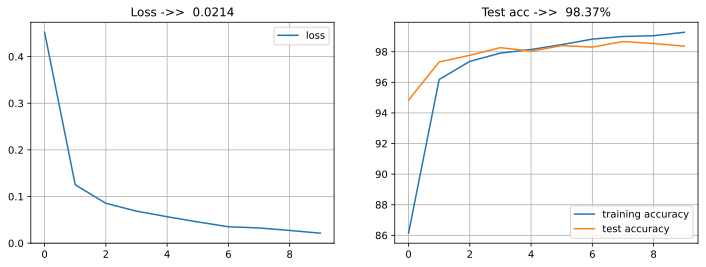

In [37]:
fig,ax = plt.subplots(1,2,figsize=(12, 4))

ax[0].plot(l)
ax[0].legend(['loss'])
ax[0].grid()
ax[0].set_title(f"Loss ->> {l[-1] : .4f}")

ax[1].plot(ta)
ax[1].plot(tea)
ax[1].legend(['training accuracy', 'test accuracy'])
ax[1].grid()
ax[1].set_title(f"Test acc ->> {tea[-1] : .2f}%")
plt.show()